In [ ]:
# Workspace problem with several narrow gaps
from model import Network

import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
import os
import csv
from random import randint, random
import time

# 1. Prepare data

In [ ]:
# neural network parameters
mb_size = 256
h_Q_dim = 512
h_P_dim = 512

c = 0
lr = 1e-4

# problem dimensions
dim = 6
dataElements = dim+3*3+2*dim # sample (6D), gap1 (2D, 1D orientation), gap2, gap3, init (6D), goal (6D)

z_dim = 3 # latent
X_dim = dim # samples
y_dim = dim # reconstruction of the original point
c_dim = dataElements - dim # dimension of conditioning variable

In [ ]:
data = np.genfromtxt("narrowDataFile.csv", delimiter=",")[:, :-1]

In [ ]:
numEntries = data.shape[0]

# split the inputs and conditions into test train (to be processed in the next step into an occupancy grid representation)
ratioTestTrain = 0.8;
numTrain = int(numEntries*ratioTestTrain)

X_train = data[0:numTrain,0:dim] # state: x, y, z, xdot, ydot, zdot
c_train = data[0:numTrain,dim:dataElements] # conditions: gaps, init (6), goal (6)

X_test = data[numTrain:numEntries,0:dim]
c_test = data[numTrain:numEntries,dim:dataElements]
numTest = X_test.shape[0]

In [ ]:
# change conditions to occupancy grid
def isSampleFree(sample, obs):
    for o in range(0, obs.shape[0]//(2*dimW)):
        isFree = 0
        for d in range(0,sample.shape[0]):
            if (sample[d] < obs[2*dimW*o + d] or sample[d] > obs[2*dimW*o + d + dimW]):
                isFree = 1
                break
        if isFree == 0:
            return 0
    return 1

In [ ]:
gridSize = 11
dimW = 3
plotOn = False;

In [ ]:
# process data into occupancy grid
conditions = data[0:numEntries,dim:dataElements]
conditionsOcc = np.zeros([numEntries,gridSize*gridSize])
occGridSamples = np.zeros([gridSize*gridSize, 2])
gridPointsRange = np.linspace(0,1,num=gridSize)

idx = 0;
for i in gridPointsRange:
    for j in gridPointsRange:
        occGridSamples[idx,0] = i
        occGridSamples[idx,1] = j
        idx += 1;

In [ ]:
start = time.time();
for j in range(0,numEntries,1):
    dw = 0.1
    dimW = 3
    gap1 = conditions[j,0:3]
    gap2 = conditions[j,3:6]
    gap3 = conditions[j,6:9]
    init = conditions[j,9:15]
    goal = conditions[j,15:21]

    obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
    obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
    obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
    obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
    obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
    obs = np.concatenate((obs1, obs2, obs3, obs4, obs5), axis=0)
    
    if j % 5000 == 0:
        print('Iter: {}'.format(j))
        
    occGrid = np.zeros(gridSize*gridSize)
    for i in range(0,gridSize*gridSize):
        occGrid[i] = isSampleFree(occGridSamples[i,:],obs)
    conditionsOcc[j,:] = occGrid
    
    if plotOn:
        fig1 = plt.figure(figsize=(10,6), dpi=80)
        ax1 = fig1.add_subplot(111, aspect='equal')
        for i in range(0,obs.shape[0]/(2*dimW)): # plot obstacle patches
            ax1.add_patch(
            patches.Rectangle(
                (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
                obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
                obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
                alpha=0.6
            ))
        for i in range(0,gridSize*gridSize): # plot occupancy grid
            if occGrid[i] == 0:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=70, alpha=0.8)
            else:
                plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=70, alpha=0.8)
        plt.show()
end = time.time();
print('Time: ', end-start)
    
cs = np.concatenate((data[0:numEntries,dim+3*dimW:dataElements], conditionsOcc), axis=1) # occ, init, goal
c_dim = cs.shape[1]
c_gapsInitGoal = c_test
c_train = cs[0:numTrain,:] 
c_test = cs[numTrain:numEntries,:]

Iter: 0
Iter: 5000
Iter: 10000
Iter: 15000
Iter: 20000
Iter: 25000
Iter: 30000
Iter: 35000
Iter: 40000
Iter: 45000
Iter: 50000
Iter: 55000
Iter: 60000
Iter: 65000
Iter: 70000
Iter: 75000
Iter: 80000
Time:  63.868316888809204


# 2. Train model

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
TRAIN = False

In [ ]:
if TRAIN:
    model = Network(X_dim, c_dim, h_Q_dim, z_dim, h_P_dim).to(DEVICE)
    model.double()
    optimizer = torch.optim.Adam(model.parameters(), lr)
    criterion1 = nn.MSELoss()
    criterion2 = lambda z_mu, z_logvar: 10**(-4) * 2 * torch.sum(torch.exp(z_logvar) + z_mu ** 2 - 1. - z_logvar, axis=1)

    X_train = torch.tensor(X_train, dtype=torch.float64).to(DEVICE)
    c_train = torch.tensor(c_train, dtype=torch.float64).to(DEVICE)

    for it in range(0, 500001):
      batch_elements = [randint(0,numTrain-1) for n in range(0,mb_size)]
      X_mb = X_train[batch_elements,:]
      c_mb = c_train[batch_elements,:]

      y, z_mu, z_logvar = model.forward(X_mb, c_mb)
      loss = torch.mean(criterion1(y, X_mb) + criterion2(z_mu, z_logvar))

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if it % 1000 == 0:
        print(f"Iter {it}, loss: {loss}")

else:
    try:
        model = torch.load("trained_model.pth").to(DEVICE)
    except FileNotFoundError as e:
        print("Model must be named 'trained_model.pth' (not found)")

# 3. Generate distribution for the maze problem

16164


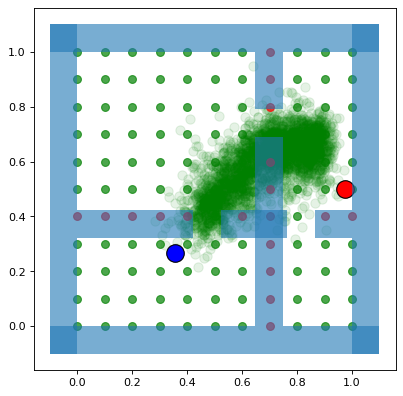

No handles with labels found to put in legend.


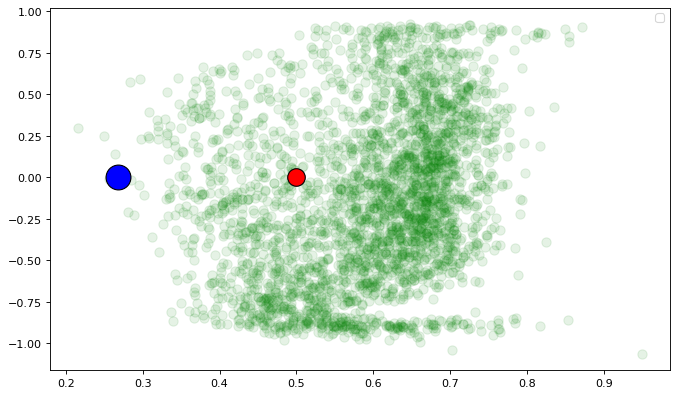

In [ ]:
# plot the latent space
num_viz = 3000

vizIdx = randint(0,numTest-1);
print(vizIdx)

c_sample_seed = c_test[vizIdx,:]
c_sample = np.repeat([c_sample_seed],num_viz,axis=0)
c_viz = c_gapsInitGoal[vizIdx,:]

z_viz = torch.randn(num_viz, z_dim).to(DEVICE)
c_sample = torch.tensor(c_sample, dtype=torch.float64).to(DEVICE)

y_viz = model.infer(z_viz, c_sample).cpu().detach().numpy()

fig1 = plt.figure(figsize=(10,6), dpi=80)
ax1 = fig1.add_subplot(111, aspect='equal')

plt.scatter(y_viz[:,0],y_viz[:,1], color="green", s=70, alpha=0.1)

dw = 0.1
dimW = 3
gap1 = c_viz[0:3]
gap2 = c_viz[3:6]
gap3 = c_viz[6:9]
init = c_viz[9:15]
goal = c_viz[15:21]

obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
            -0.1, -0.1, -0.5, 1.1, 0, 1.5,
            -0.1, 1, -0.5, 1.1, 1.1, 1.5,
            1, -0.1, -0.5, 1.1, 1.1, 1.5,]

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)
for i in range(0,obs.shape[0]//(2*dimW)):
    ax1.add_patch(
    patches.Rectangle(
        (obs[i*2*dimW], obs[i*2*dimW+1]),   # (x,y)
        obs[i*2*dimW+dimW] - obs[i*2*dimW],          # width
        obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1],          # height
        alpha=0.6
    ))
    
for i in range(0,gridSize*gridSize): # plot occupancy grid
    cIdx = i + 2*dim
    if c_sample_seed[cIdx] == 0:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="red", s=50, alpha=0.7)
    else:
        plt.scatter(occGridSamples[i,0], occGridSamples[i,1], color="green", s=50, alpha=0.7)

plt.scatter(init[0], init[1], color="red", s=250, edgecolors='black') # init
plt.scatter(goal[0], goal[1], color="blue", s=250, edgecolors='black') # goal

plt.show()

plt.figure(figsize=(10,6), dpi=80)
viz1 = 1;
viz2 = 4;
plt.scatter(y_viz[:,viz1],y_viz[:,viz2], color="green", s=70, alpha=0.1)
plt.scatter(c_viz[viz1+9],c_viz[viz2+9], color="red", s=250, edgecolors='black') # init
plt.scatter(c_viz[viz1+9+dim],c_viz[viz2+9+dim], color="blue", s=500, edgecolors='black') # goal
plt.legend()
plt.show()

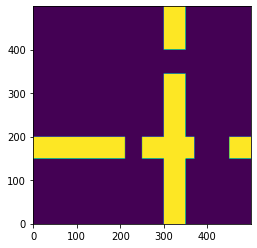

In [ ]:
n_size=50
dw=0.1
dim_size=int(n_size/0.1)
space=np.zeros((dim_size,dim_size))
obs1 = [0, gap1[1]-dw, -0.5,             gap1[0], gap1[1], 1.5]
obs2 = [gap2[0]-dw, 0, -0.5,             gap2[0], gap2[1], 1.5];
obs3 = [gap2[0]-dw, gap2[1]+dw, -0.5,    gap2[0], 1, 1.5];
obs4 = [gap1[0]+dw, gap1[1]-dw, -0.5,    gap3[0], gap1[1], 1.5];
obs5 = [gap3[0]+dw, gap1[1]-dw, -0.5,    1, gap1[1], 1.5];
obsBounds = [-0.1, -0.1, -0.5, 0, 1.1, 1.5,
            -0.1, -0.1, -0.5, 1.1, 0, 1.5,
            -0.1, 1, -0.5, 1.1, 1.1, 1.5,
            1, -0.1, -0.5, 1.1, 1.1, 1.5,]

obs = np.concatenate((obs1, obs2, obs3, obs4, obs5, obsBounds), axis=0)

for i in range(0,int(obs.shape[0]/(2*dimW))):
     x=round(obs[i*2*dimW],1)*10*n_size
     y=round(obs[i*2*dimW+1],1)*10*n_size
     width=round(n_size*(obs[i*2*dimW+dimW] - obs[i*2*dimW]),1)*10
     height=round(n_size*(obs[i*2*dimW+dimW+1] - obs[i*2*dimW+1]),1)*10 
     y2=abs(int(y+height))
     x2=abs(int(x+width))
     x=abs(x)
     y=abs(y)
     space[int(y):y2,int(x):x2]=1
samples_xy=y_viz[:,:2]*n_size*10
plt.imshow(space,origin='lower')

In [ ]:
import math
import random
start0=(round(init[0]*n_size,1)*10),int(round(init[1]*n_size,1)*10)
goal0=(round(goal[0]*n_size,1)*10),int(round(goal[1]*n_size,1)*10)
class Node():
  def __init__(self,parent=None,position=None):
    self.parent=parent
    self.position=position
def cost(node1, node2):
    node1=np.array(node1)
    node2=np.array(node2)
    x=np.linalg.norm(node1-node2)
    return x

def get_nearest(nodes, rand_node):
    dist = [cost(a.position, rand_node.position) for a in nodes]
    min_node = dist.index(min(dist))
    return nodes[min_node]

def difference(node1,node2):
    node1_position =np.array(node1.position )
    node2_position =np.array(node2.position )
    delta= node2_position-node1_position 
    dist=math.sqrt(delta[0]**2+delta[1]**2)
    theta=math.atan2(delta[1],delta[0])
    return dist,theta

def steer(openSet,nearest_node, rand_node,max_length):

    d,theta=difference(nearest_node,rand_node)
    if d>max_length:
        d=max_length
    
    x=nearest_node.position[0]+d*math.cos(theta)
    y=nearest_node.position[1]+d*math.sin(theta)

#     print(sign_dir,nearest_node.orientation,rand_node.orientation,ang)
    new_node=Node(nearest_node,(x , y))
    return new_node
def check_collision(space,x1,y1,x2,y2):
  b=False

  xs=np.linspace(start=x1, stop=x2, num=4)
  ys=np.linspace(start=y1, stop=y2, num=4)
  for x,y in zip(xs,ys):
    print(x,y,space[int(x),int(y)])
    if space[int(x),int(y)]==1:
       return 1
  return b



def rrt(space, start, end, step,samples_xy):
    
    start_node = Node(None, start)
    end_node = Node(None, end)
    openSet   = [start_node]
    i=0
    path=[]
    max_length=5
    while i<step:     
        i=i+1
        p = np.random.rand(1)
        # p=0.6
        if p>=1:
            
            pos=(randint(0, (n_size*10-1)*10)*0.1 , randint(0, (n_size*10-1)*10)*0.1)
        else:
            pos = random.choice(samples_xy)

        node=Node(None, pos)
        nearest=get_nearest(openSet,node)
        new_node=steer(openSet, nearest, node, max_length)
        x_s=int(new_node.position[1])
        y_s=int(new_node.position[0])
        
        # if check_collision(space,x_s,y_s,nearest.position[1],nearest.position[0]):
        #   continue
        if space[x_s,y_s]==1:
          continue
            
        openSet.append(new_node)

        # print(y_s,x_s)

#solution set
        if cost(new_node.position,end_node.position)<=20:
            print("Almost found")
            print(new_node.position[::-1],end_node.position[::-1])
            if space[int(new_node.position[1]),int(new_node.position[0])]==1:
                continue
            end_node.parent=new_node
            openSet.append(end_node)
            current = end_node
            while current is not None:
                path.append((current.position[0],current.position[1]))
                current = current.parent
                
            print("Length of path: ", len(path))
            print("Iterations: ",i)
            return openSet,path[::-1]
    return openSet, path

start0,goal0

((487.0, 250), (178.0, 134))

In [ ]:
openSet, path = rrt(space,start0,goal0,5000,samples_xy)

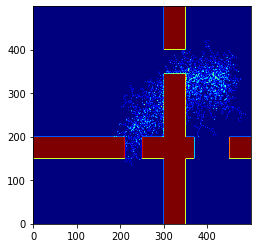

In [ ]:
space_observed=space.copy()
for n in openSet:
  space_observed[int(n.position[1]),int(n.position[0])]=1
plt.imshow(space_observed,origin='lower',cmap='jet')

In [ ]:
# path

[(487.0, 250),
 (482.6469968354513, 252.45995192014584),
 (480.8815830354111, 257.1379123854157),
 (477.55326900707155, 260.8691756740028),
 (475.19525780767503, 265.2782326234559),
 (470.9006526080021, 267.83877283578255),
 (465.96649336521125, 268.64752036547384),
 (461.46868374349725, 270.83148662135255),
 (456.5426458558171, 269.97466065936277),
 (451.6138094887409, 270.81523907128354),
 (448.1665476751831, 274.4368942162119),
 (443.40430238603693, 275.96038356832605),
 (438.4207298846234, 275.5554081083842),
 (435.3129069665825, 279.4722227210637),
 (431.49297222467345, 282.69838120563264),
 (426.4971508148866, 282.49400791599993),
 (421.6902973709383, 283.8702927587568),
 (417.0875505072791, 281.91716160364314),
 (412.4097280986953, 283.68294118041695),
 (409.12009601462364, 287.448352280343),
 (404.71617152400927, 289.81593524213486),
 (403.25378817025444, 294.5972985337768),
 (398.26054417400786, 294.33746321295274),
 (393.3040452107868, 293.6793461811199),
 (392.3032833812507,

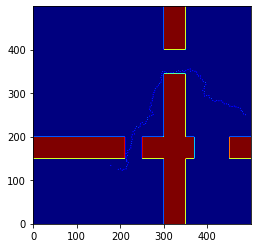

In [ ]:
space_path=space.copy()
for n in path:
  space_path[int(n[1]),int(n[0])]=1
plt.imshow(space_path,origin='lower',cmap='jet')